### **코비 브라이언트의 슛 성공 여부 예측**

故 코비 브라이언트 선수의 NBA 필드 골 시도들이 담긴 데이터셋을 다룹니다 (1996년 11월 3일부터 2016년 4월 13일까지의 정규 시즌과 플레이오프 시즌 기록).

각 슛의 성공 여부를 슈팅의 대한 정보, 게임에 대한 정보를 통해서 예측해보도록 하겠습니다. 해당 데이터셋은 [NBA API]((https://github.com/swar/nba_api) 파이썬 라이브러리를 통해 수집됐습니다.

&nbsp;

* 전처리
* 모델링
* Confusion Matrix

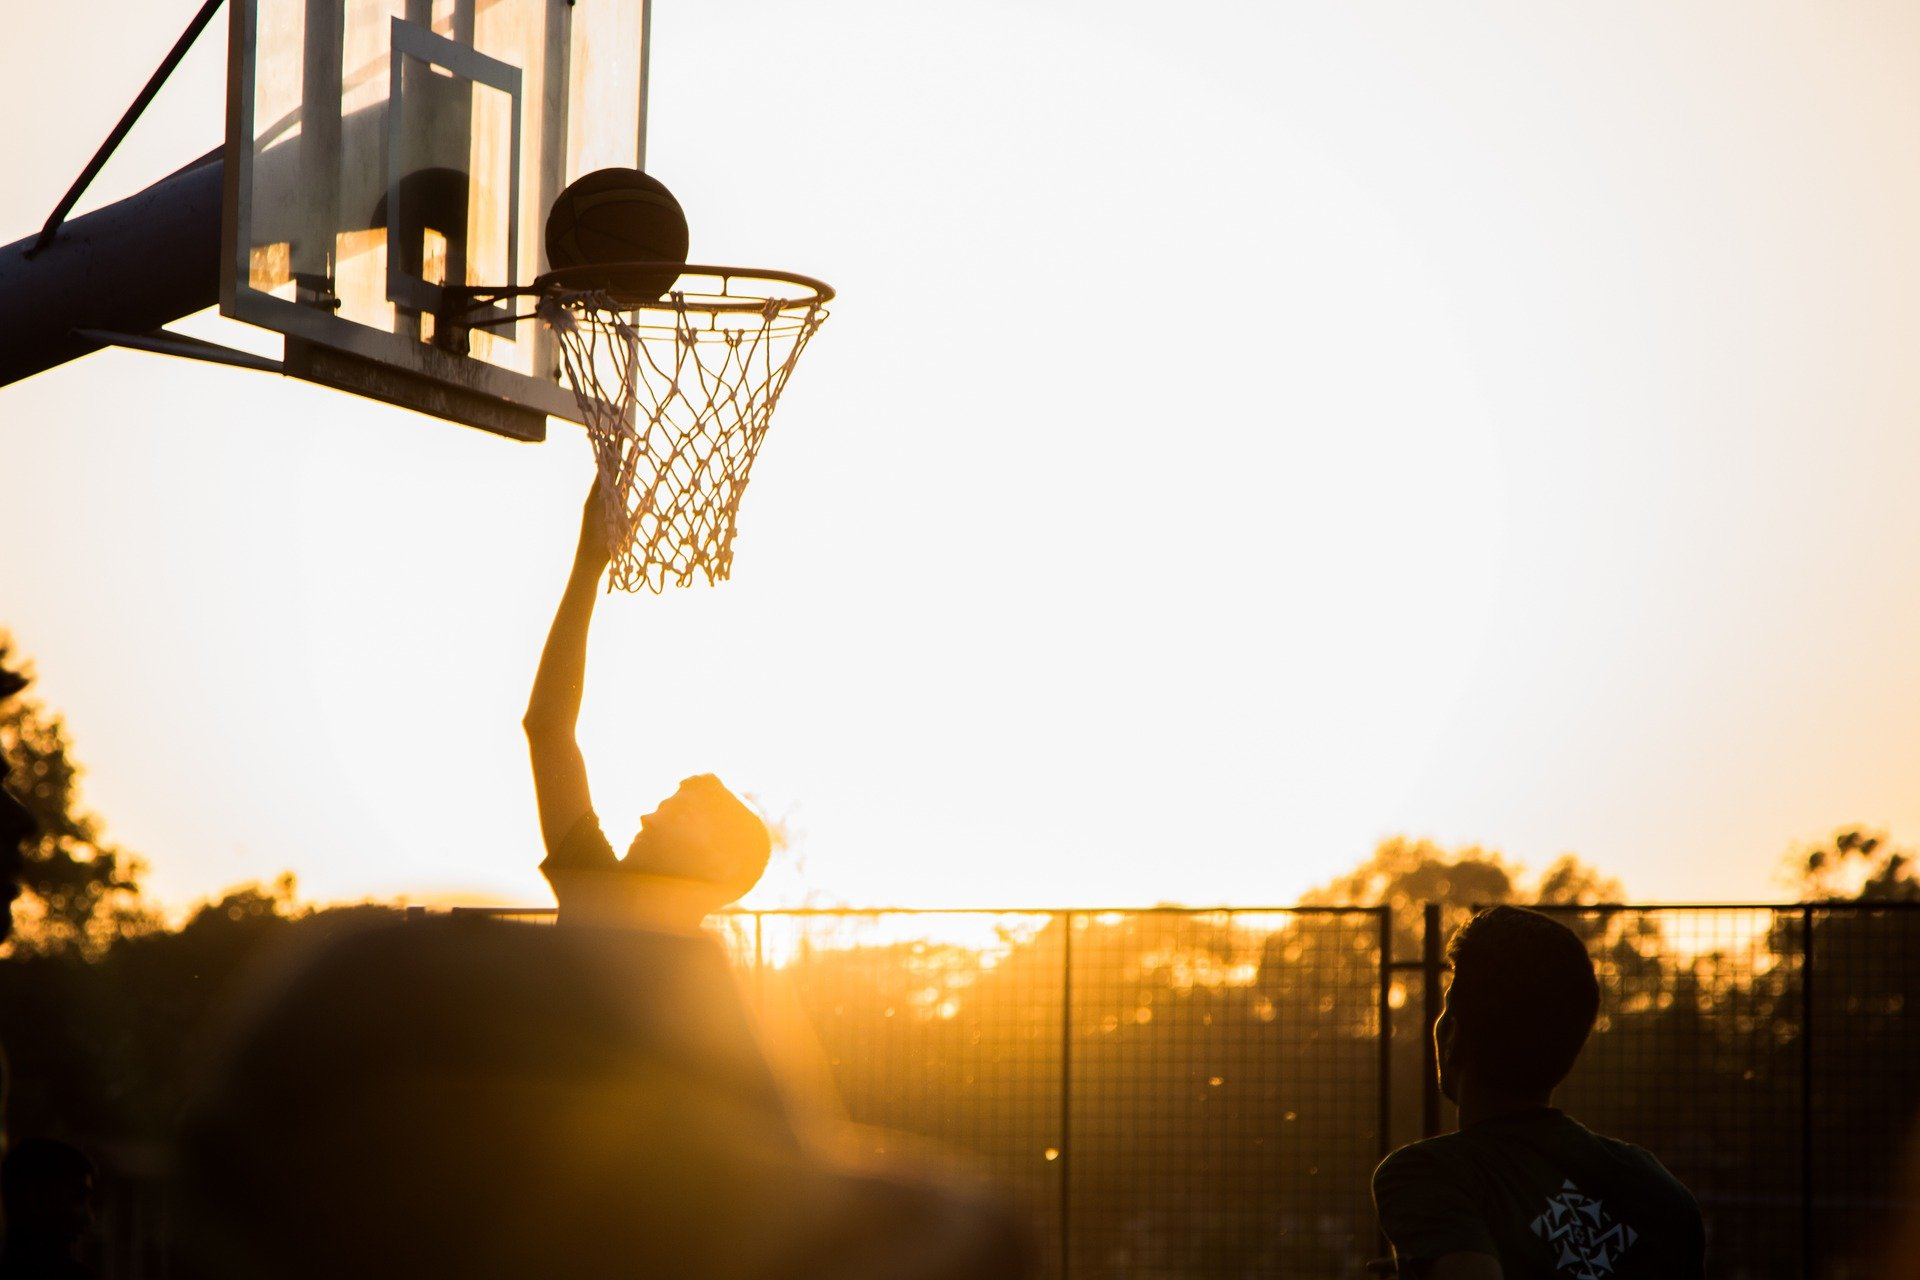

---

In [ ]:
# Google Colab으로 수행하므로 해당 셀 실행

%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install pandas-profiling==2.*

In [ ]:
# 데이터셋을 불러옵니다.

import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/nba/nba_kobe_bryant.csv'
df = pd.read_csv(url)

# 데이터셋이 잘 불러졌는지 확인합니다
assert df.shape == (30697, 19)

In [ ]:
df.head(2)

,game_id,game_event_id,player_name,period,minutes_remaining,seconds_remaining,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type
0,29600027,102,Kobe Bryant,1,0,42,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,1996-11-03,LAL,MIN,Regular Season
1,29600031,127,Kobe Bryant,2,10,8,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,1996-11-05,NYK,LAL,Regular Season


## **Data Preprocessing**

### **분류를 위한 베이스라인 정확도 계산**

>예측 해야하는 target은 `shot_made_flag` 입니다. 전체 데이터를 써서 baseline **accuracy score**를 계산해보겠습니다.

In [ ]:
!pip install category_encoders

In [ ]:
# 필요한 라이브러리 import 

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from category_encoders import *
from random import randint

### **모델의 예측 정확도를 시험하기 위한 test set 구현**

> 예측 모델 시험을 위해 **2014-15** ~ **2015-16** 시즌을 `test set`으로 만듭니다.

In [ ]:
# game_date를 숫자형으로 바꾼 후, 조건에 맞게 train, test 분할합니다.

df.game_date=pd.to_numeric(df.game_date.str.replace("-",""))

train = df[~((df['game_date']>=20140626) & (df['game_date']<=20160629))]
test = df[(df['game_date']>=20140626) & (df['game_date']<=20160629)]

### **새로운 feature 생성**
    

In [ ]:
# 시간 데이터를 활용해 새로운 feature 만들기

df['remain_time'] = (df['period']*12  + df['minutes_remaining'] + df['seconds_remaining']/60).round(3)

#필요 없는 컬럼이 된 숫자 관련 feature는 삭제하기
df= df.drop(['period','minutes_remaining','seconds_remaining'],axis=1)
df.head(3)

,game_id,game_event_id,player_name,action_type,shot_type,shot_zone_basic,shot_zone_area,shot_zone_range,shot_distance,loc_x,loc_y,shot_made_flag,game_date,htm,vtm,season_type,remain_time
0,29600027,102,Kobe Bryant,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,18,-140,116,0,19961103,LAL,MIN,Regular Season,12.700
1,29600031,127,Kobe Bryant,Jump Shot,2PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,16,-131,97,0,19961105,NYK,LAL,Regular Season,34.133
2,29600044,124,Kobe Bryant,Jump Shot,3PT Field Goal,Mid-Range,Left Side Center(LC),16-24 ft.,23,-142,181,1,19961106,CHH,LAL,Regular Season,32.617


In [ ]:
# action 카테고리가 많으므로, 삭제해주기
action = df['action_type'].str.split(' ').str[:-1]
df['action_a'] = action.str[0]
df['action_b'] = action.str[1]
df['action_c'] = action.str[2]

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 20 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   game_id          30697 non-null  int64  
 1   game_event_id    30697 non-null  int64  
 2   player_name      30697 non-null  object 
 3   action_type      30697 non-null  object 
 4   shot_type        30697 non-null  object 
 5   shot_zone_basic  30697 non-null  object 
 6   shot_zone_area   30697 non-null  object 
 7   shot_zone_range  30697 non-null  object 
 8   shot_distance    30697 non-null  int64  
 9   loc_x            30697 non-null  int64  
 10  loc_y            30697 non-null  int64  
 11  shot_made_flag   30697 non-null  int64  
 12  game_date        30697 non-null  int64  
 13  htm              30697 non-null  object 
 14  vtm              30697 non-null  object 
 15  season_type      30697 non-null  object 
 16  remain_time      30697 non-null  float64
 17  action_a    

In [ ]:
# action의 중분류,소분류의 null값이 50% 이상이므로, 해당 feature는 삭제해주기
df=df.drop(['action_b','action_c','action_type'],axis=1)

In [ ]:
# 필요하지 않은 데이터(game_id, game_event_id) 삭제하기
df.drop(['game_id','game_event_id'],axis=1,inplace=True)

In [ ]:
# 필요하지 않은 데이터(player_name) 삭제하기
df.drop(['player_name'],axis=1,inplace=True)

### **데이터셋 분할**


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   shot_type        30697 non-null  object 
 1   shot_zone_basic  30697 non-null  object 
 2   shot_zone_area   30697 non-null  object 
 3   shot_zone_range  30697 non-null  object 
 4   shot_distance    30697 non-null  int64  
 5   loc_x            30697 non-null  int64  
 6   loc_y            30697 non-null  int64  
 7   shot_made_flag   30697 non-null  int64  
 8   game_date        30697 non-null  int64  
 9   htm              30697 non-null  object 
 10  vtm              30697 non-null  object 
 11  season_type      30697 non-null  object 
 12  remain_time      30697 non-null  float64
 13  action_a         30697 non-null  object 
dtypes: float64(1), int64(5), object(8)
memory usage: 3.3+ MB


In [ ]:
df.nunique()

shot_type             2
shot_zone_basic       7
shot_zone_area        6
shot_zone_range       5
shot_distance        74
loc_x               489
loc_y               457
shot_made_flag        2
game_date          1559
htm                  36
vtm                  36
season_type           2
remain_time        3080
action_a             19
dtype: int64

In [ ]:
# 무작위로 비율 나눠 데이터셋을 분할합니다.
target='shot_made_flag'

X_train, X_test, y_train, y_test = train_test_split(df.drop([target],axis=1), df[target], test_size =0.3)
for i in X_train, X_test, y_train, y_test : i.reset_index(drop=True,inplace=True)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size =0.3)
for i in X_train, X_val, y_train, y_val : i.reset_index(drop=True,inplace=True)

## **Modeling & Evaluation**

### 범주형 feature를 인코딩하고 DecisionTree 혹은 RandomForest를 이용한 학습까지 완료하는 파이프라인 구축
>Scikit-learn의 `pipeline`을 활용할 예정입니다.

In [ ]:
# Encoder 선택 위해 데이터 살펴보기
X_train.shot_zone_range.unique() #  Category 분류
df.isnull().sum()

shot_type          0
shot_zone_basic    0
shot_zone_area     0
shot_zone_range    0
shot_distance      0
loc_x              0
loc_y              0
shot_made_flag     0
game_date          0
htm                0
vtm                0
season_type        0
remain_time        0
action_a           0
dtype: int64

In [ ]:
pipe_cat = make_pipeline(
    TargetEncoder(),
    StandardScaler(),
    SelectKBest(),
    RandomForestClassifier())

In [ ]:
dists = {
    'randomforestclassifier__min_samples_leaf':[3,5,7],
    'selectkbest__k': range(10,len(X_train.columns)+1),
    'randomforestclassifier__max_depth': range(8,15)}

reg = RandomizedSearchCV(
    pipe_cat, 
    param_distributions=dists, 
    n_iter=100,
    cv=4
)

reg.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univariate_selection.py:114: UserWarning: Features [0] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/_univ

AttributeError: ignored

In [ ]:
pipe_cat=reg.best_estimator_

### **검증셋 활용해 예측 정확도(accuracy score)를 계산**

In [ ]:
pred = pipe_cat.predict(X_val)
accuracy_score(pred,y_val)

0.6722506592213433

### **테스트셋 활용해 예측 정확도(accuracy score)를 계산**

In [ ]:
# 추후, 검증셋과 학습셋을 합쳐 테스트셋에 대해 정확도를 1회 계산하는 방향으로 검증해보아야 한다.
pred = pipe_cat.predict(X_test)
accuracy_score(pred,y_test)

0.6767643865363735

## **Confusion Matrix**
confusion matrix를 사용해서 accuracy, precision, recall을 계산해보겠습니다.

**a) Accuracy score 계산**

In [ ]:
tp = 36
fp = 58
tn = 85
fn = 8

In [ ]:
tp/(tp+tn)

0.2975206611570248

**b) Precision score를 계산**

In [ ]:
tp/(tp+fp)

0.3829787234042553

**c) Recall score를 계산**

In [ ]:
# 이 곳에 답안을 작성하십시오
tp/(tp+fn)

0.8181818181818182